In [1]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cpu].
CPU times: user 1.91 s, sys: 458 ms, total: 2.37 s
Wall time: 1.57 s


In [2]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 3.95 s, sys: 225 ms, total: 4.17 s
Wall time: 4.17 s


In [3]:
class FactorizationMachine(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(FactorizationMachine, self).__init__()
        
        self.embed1 = FeaturesEmbedding(field_dims, 1)
        self.embed2 = FeaturesEmbedding(field_dims, embed_dim)
        self.bias = nn.Parameter(torch.zeros((1, )))
        
    def forward(self, x):
        # x shape: (batch_size, num_fields)
        # embed(x) shape: (batch_size, num_fields, embed_dim)
        square_sum = self.embed2(x).sum(dim=1).pow(2).sum(dim=1)
        sum_square = self.embed2(x).pow(2).sum(dim=1).sum(dim=1)
        output = self.embed1(x).squeeze(-1).sum(dim=1) + self.bias + (square_sum + sum_square) / 2
        output = torch.sigmoid(output).unsqueeze(-1)
        return output


 24%|██▎       | 141/600 [02:03<06:41,  1.14it/s]


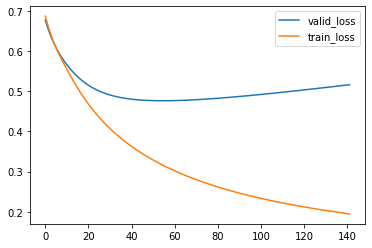

train_loss: 0.35623 | train_metric: 0.90703
valid_loss: 0.47946 | valid_metric: 0.74905
test_loss:  0.46851 | test_auc:  0.75755
CPU times: user 6min 47s, sys: 44.6 s, total: 7min 31s
Wall time: 2min 3s


In [4]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

fm = FactorizationMachine(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(fm.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(fm, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
